In [1]:
from cell_env import CellEnv
# Use sb3 env checker:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO, DQN

In [2]:
# Load the best model from rl-models:
model = DQN.load("rl-models/best_model_bangbang02.zip")


In [6]:
import matplotlib.pyplot as plt
import numpy as np

from gymnasium.wrappers import TimeLimit
def evaluate_model(env_class, max_steps, num_episodes, model=None):
    """
    Evaluate the model over several episodes and plot the results.

    Parameters:
    - model: Trained RL model to be evaluated.
    - env_class: Environment class to create new instances of the evaluation environment.
    - max_steps: Maximum number of steps per episode.
    - num_episodes: Number of episodes to evaluate.

    Returns:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    all_observations = []


    for _ in range(num_episodes):
        eval_env = TimeLimit(env_class(frame_stack=4, dt=0.2), max_steps)
        done = False
        obs, _ = eval_env.reset()
        episode_observations = []
        while not done:
            if model is not None:
                action, _states = model.predict(obs)
            else:
                action = eval_env.action_space.sample()
            obs, rewards, term, trunc, info = eval_env.step(action)
            done = term or trunc
            episode_observations.append(info['n_cells'])
        
        all_observations.append(episode_observations)
    
    # Compute the average observations
    max_len = max(len(obs) for obs in all_observations)
    avg_observations = np.zeros(max_len)
    counts = np.zeros(max_len)
    
    for obs in all_observations:
        for i, val in enumerate(obs):
            avg_observations[i] += val[-1]
            counts[i] += 1
    
    avg_observations /= counts

    return avg_observations, all_observations




def plot_observations(avg_observations, all_observations, unif_obs=None, all_unif_obs=None):
    """
    Plot the average observations and individual episode tracks.

    Parameters:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    plt.figure(figsize=(12, 8))
    max_steps = len(avg_observations)
    x_axis = np.linspace(0, 0.15*max_steps, max_steps)

    # Plot individual episode tracks with lower alpha
    for obs in all_observations:
        plt.plot(x_axis, obs, alpha=0.05, linewidth=0.5, color='black')

    if unif_obs is not None:
        for obs in all_unif_obs:
            plt.plot(x_axis, obs, alpha=0.05, linewidth=0.5, color='red')
    
    # Plot average observations
    plt.plot(x_axis, avg_observations, label='trained policy', linewidth=3, color='black')
    if unif_obs is not None:
        plt.plot(x_axis, unif_obs, label='random policy', linewidth=3, color='red')
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Total cells (n_cells)')
    plt.title('Model Evaluation: Average Observations and Individual Episode Tracks')
    plt.legend()
    # plt.yscale('log')
    plt.show()


In [11]:
# Example usage:
avg_obs, all_obs = evaluate_model(CellEnv, 100, 10, model)
unif_obs, unif_all_obs = evaluate_model(CellEnv, 100, 10)

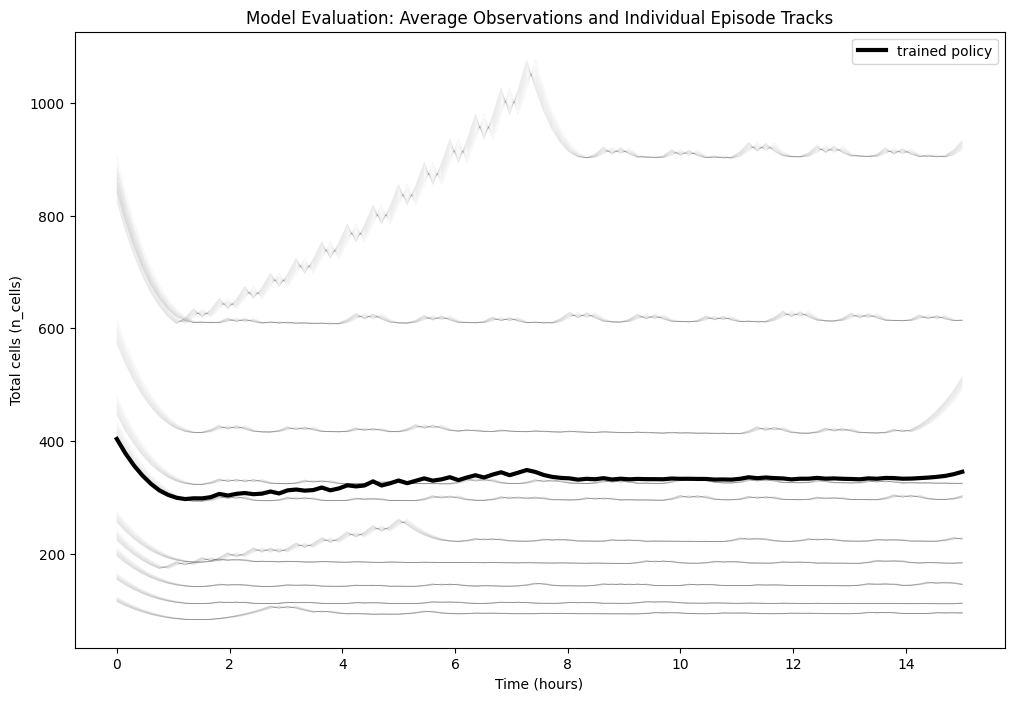

In [12]:
plot_observations(avg_obs, all_obs)#, unif_obs, unif_all_obs)

In [9]:

def get_actions(model, env_class, max_steps, num_episodes=1):
    """
    Evaluate the model over several episodes and plot the results.

    Parameters:
    - model: Trained RL model to be evaluated.
    - env_class: Environment class to create new instances of the evaluation environment.
    - max_steps: Maximum number of steps per episode.
    - num_episodes: Number of episodes to evaluate.

    Returns:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    all_actions = []


    for _ in range(num_episodes):
        eval_env = TimeLimit(env_class(frame_stack=4, dt=0.2), max_steps)
        done = False
        obs, _ = eval_env.reset()
        episode_actions = []
        while not done:
            if model is not None:
                action, _states = model.predict(obs)
            else:
                action = eval_env.action_space.sample()
            obs, rewards, term, trunc, info = eval_env.step(action)
            done = term or trunc
            episode_actions.append(action)
        
        all_actions.append(episode_actions)
    
    # Compute the average observations
    max_len = max(len(obs) for obs in all_actions)
    avg_actions = np.zeros(max_len)
    counts = np.zeros(max_len)
    
    for obs in all_actions:
        for i, val in enumerate(obs):
            avg_actions[i] += val
            counts[i] += 1
    
    avg_actions /= counts

    return avg_actions




def plot_actions(avg_actions):
    """
    Plot the average observations and individual episode tracks.

    Parameters:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    plt.figure(figsize=(12, 8))
    max_steps = len(avg_actions)
    x_axis = np.linspace(0, 0.15*max_steps, max_steps)

    # Plot average observations
    # plt.plot(x_axis, avg_actions, label='trained policy', linewidth=3, color='black')
    # do a sliding window average
    # window_size = 20
    # avg_actions_smooth = np.convolve(avg_actions, np.ones(window_size)/window_size, mode='valid')
    # x_axis = np.linspace(0, 0.15*len(avg_actions_smooth), len(avg_actions_smooth))
    # plt.plot(x_axis, avg_actions_smooth, label='trained policy', linewidth=3, color='black')
    # try calculating frequency of actions with fourier transform
    avg_actions = np.array(avg_actions)
    avg_actions = avg_actions - np.mean(avg_actions)
    avg_actions = np.abs(np.fft.fft(avg_actions))
    avg_actions = avg_actions[:len(avg_actions)//2]
    x_axis = np.linspace(0, 0.15*len(avg_actions), len(avg_actions))
    plt.plot(x_axis, avg_actions, label='trained policy', linewidth=3, color='black')

     

    # plt.xlabel('Time (hours)')
    plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Action (use of drug)')
    plt.ylabel('Counts')
    plt.title('Model Evaluation: Action usage')
    plt.legend()
    # plt.yscale('log')
    plt.show()


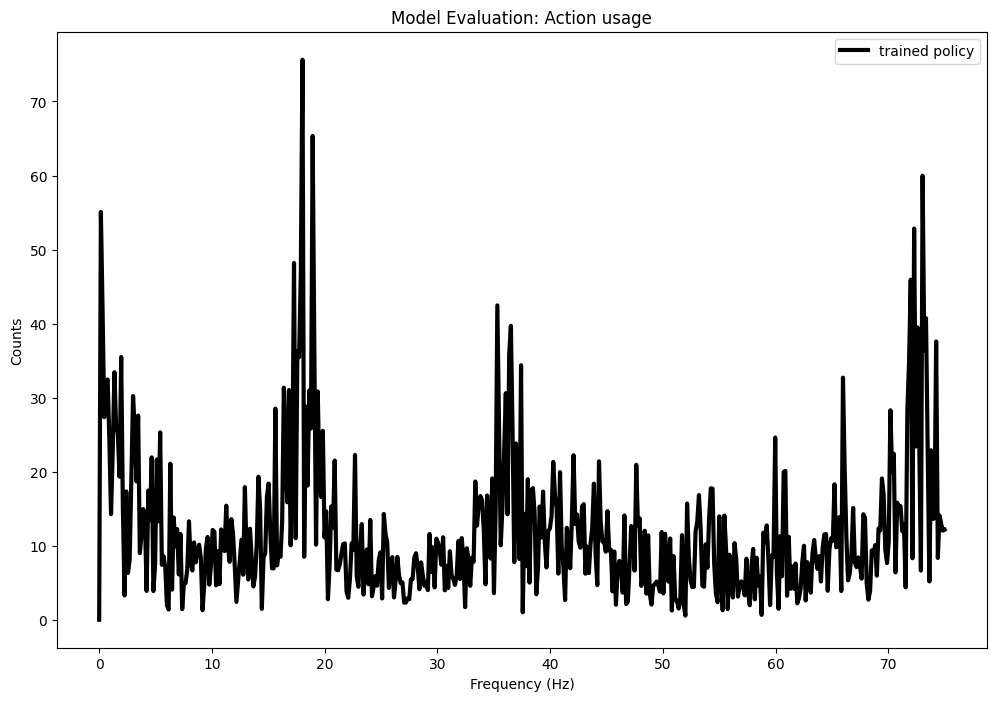

In [10]:
# view actions:
avg_actions = get_actions(model, CellEnv, 1000, 1)
plot_actions(avg_actions)